# TP 3: Hasting-Metropolis (and Gibbs) samplers

In [6]:
# imports 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import invwishart
from tqdm import tqdm
import scipy
np.random.seed(2024)

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

#### 1. Write the complete log-likelihood of the previous model $ \log q(y, z, \theta ) $ and show that the proposed model belongs to the curved exponential family.

Cf pdf file.

#### 2. Generate synthetic data from the model by taking some reasonable values for the parameters.

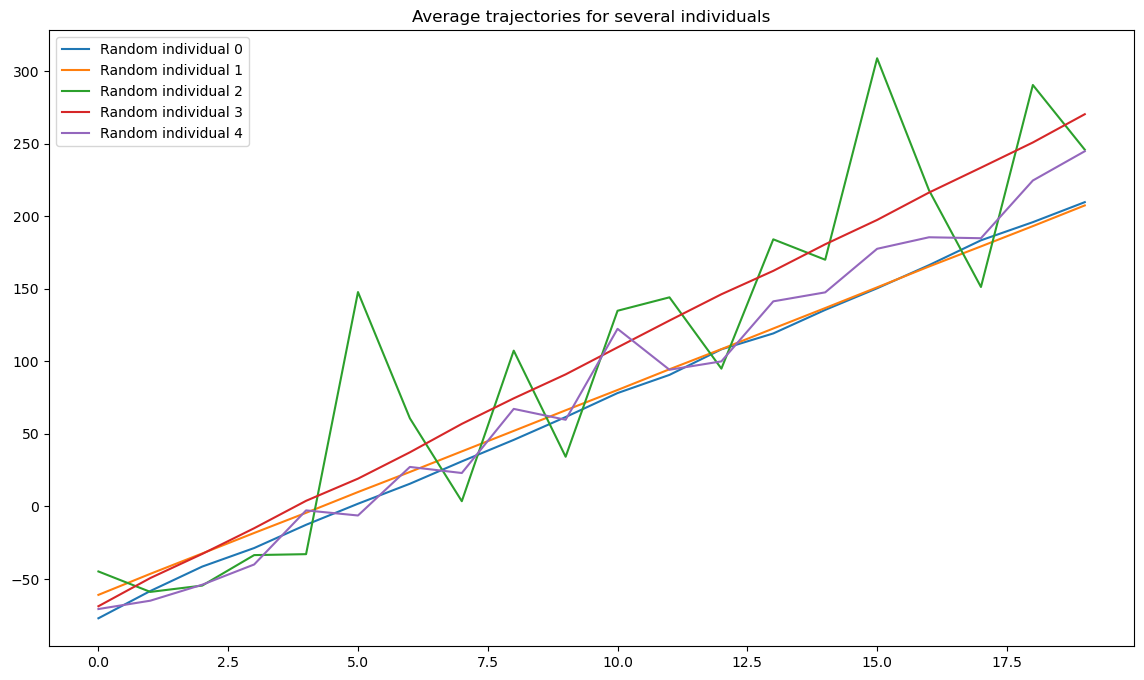

In [17]:
def average_trajectory(p_0, v_0, t_0):
    """ Returns a function that gives the average trajectory
    with initial position p_0, initial velocity v_0, and initial time t_0."""
    return lambda t: p_0 + v_0 * (t - t_0)

def individual_trajectory(p_0, v_0, t_0, alpha_i, tau_i):
    """ Returns a function that gives the individual trajectory
    """
    aver_traj = average_trajectory(p_0, v_0, t_0)
    return lambda t: aver_traj(alpha_i * (t - t_0 - tau_i) + t_0)

def initialize_parameters():
    """ Returns the initial parameters for the model.
    """
    N = 1000
    ki = 20 
    p_0 = 1    # we consider straight line trajectories
    sigma_p0 = 0.1
    sigma_v0 = 0.1
    sigma_t0 = 0.1
    s_t0 = 0.5
    s_v0 = 0.5
    t0_barbar = 5
    v0_barbar = 10
    return N, ki, p_0, sigma_p0, sigma_v0, sigma_t0, s_t0, s_v0, t0_barbar, v0_barbar

def generate_data(n_samples = 10 ** 4):
    """ Returns the generated data.
    """
    N, ki, p_0, sigma_p0, sigma_v0, sigma_t0, s_t0, s_v0, t0_barbar, v0_barbar = initialize_parameters()
    Y = []        # [(N,ki) * n_samples]

    t0_bar = np.random.normal(t0_barbar, s_t0, n_samples)    #time
    v0_bar = np.random.normal(v0_barbar, s_v0, n_samples)    #velocity
    sigma_eps = invwishart.rvs(df = 3, scale = 0.5, size = n_samples)
    sigma_tau = invwishart.rvs(df = 3, scale = 0.5, size = n_samples)
    sigma = invwishart.rvs(df = 5, scale = 10, size = (n_samples, N))
    t_0 = np.random.normal(t0_bar, sigma_t0, n_samples)
    v_0 = np.random.normal(v0_bar, sigma_v0, n_samples)
    epsilons_i = np.random.normal(0, sigma_eps, (N, n_samples))
    alpha_i = np.exp(epsilons_i)    # size = (N, n_samples)
    tau_i = np.random.normal(0, sigma_tau, (N, n_samples))

    for n in tqdm(range(n_samples)):
        # generate the data for the n-th sample
        d = average_trajectory(p_0, v_0[n], t_0[n])
        y_i = []
        # in the n-th sample, we have N individuals with ki measurements
        for i in range(N):
            epsilon_i_j = np.random.normal(0, sigma[n, i], size = ki)   # for individual i
            d_i = individual_trajectory(p_0, v_0[n], t_0[n], alpha_i[i, n], tau_i[i, n])    # individual trajectory
            y_i_j = [d_i(j) for j in range(1, ki + 1)] + epsilon_i_j   # size = (N, ki)
            y_i.append(y_i_j)
        Y.append(y_i)
    return np.array(Y)

def generate_data_single():
    """ Returns the generated data.
    """
    N, ki, p_0, sigma_p0, sigma_v0, sigma_t0 = initialize_parameters()
    t0_bar = np.random.normal(5, 0.5)    #time
    v0_bar = np.random.normal(10, 0.5)    #velocity
    sigma_eps = invwishart.rvs(df = 2, scale = 0.5)
    sigma_tau = invwishart.rvs(df = 2, scale = 0.5)
    sigma = invwishart.rvs(df = 1.5, scale = 0.5, size = N)
    t_0 = np.random.normal(t0_bar, sigma_t0)
    v_0 = np.random.normal(v0_bar, sigma_v0)
    epsilons_i = np.random.normal(0.5, sigma_eps, N)
    alpha_i = np.exp(epsilons_i)    # size = (N, n_samples)
    tau_i = np.random.normal(0, sigma_tau, N)
    d = average_trajectory(p_0, v_0, t_0)
    Y = []
    for i in range(N):
        epsilon_i_j = np.random.normal(0, sigma[i], size = ki)   # for individual i
        d_i = individual_trajectory(p_0, v_0, t_0, alpha_i[i], tau_i[i])    # individual trajectory
        y_i = [d_i(j) for j in range(ki)] + epsilon_i_j   # size = (N, ki)
        Y.append(y_i)
    Y.append(y_i)
    return np.array(Y)


Y = generate_data_single()
plt.figure(figsize = (14, 8))
plt.title("Average trajectories for several individuals")
sample_index = np.random.choice(range(Y.shape[0]), 5, replace = False)
sample = Y[sample_index]
for i in range(5):
    plt.plot(range(Y.shape[1]), sample[i, :], label = f"Random individual {i}")
plt.legend()
plt.show()

#### 3. Propose a Metropolis-Hastings sampler to sample from the a posteriori distribution $(z | y, θ)$.

100%|██████████| 100/100 [00:12<00:00,  7.99it/s]

Acceptance rate for sigma proposal = 0.015 is :  0.28


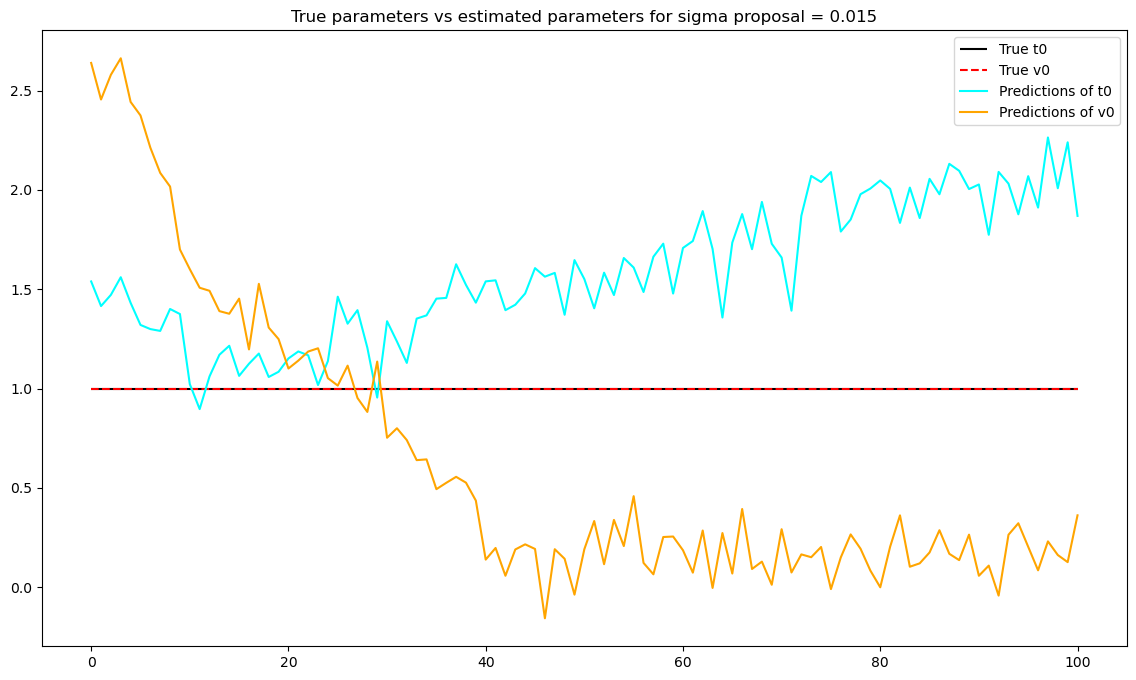

100%|██████████| 100/100 [00:12<00:00,  7.92it/s]

Acceptance rate for sigma proposal = 0.01 is :  0.3


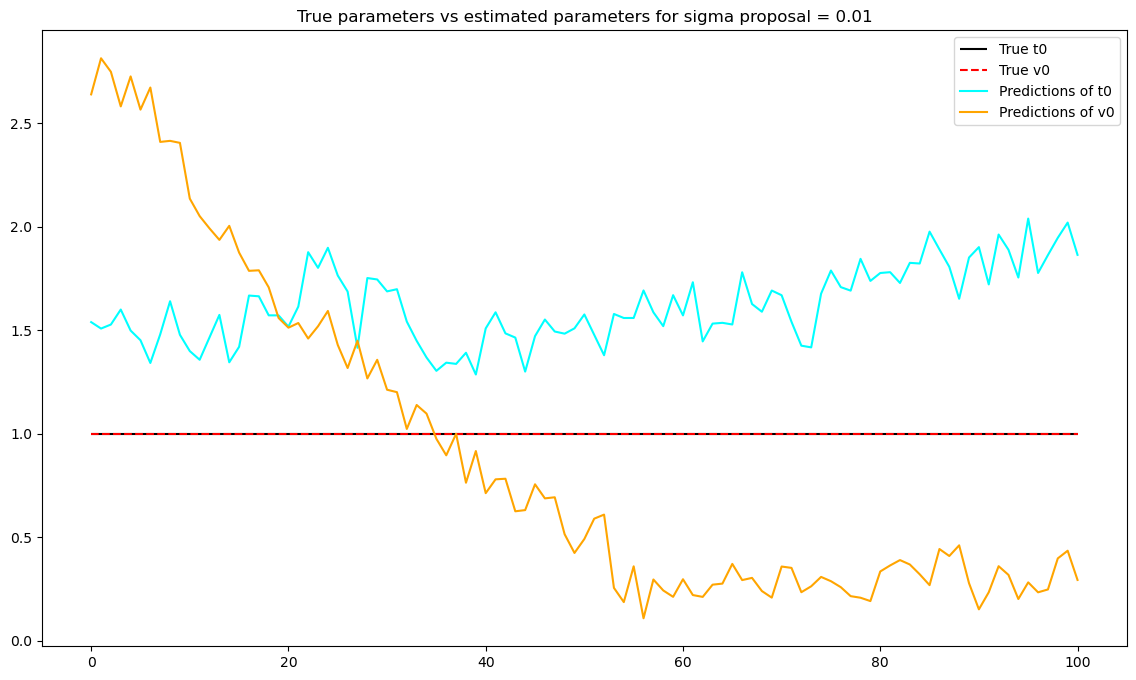

100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Acceptance rate for sigma proposal = 1.0413797439924106 is :  0.03


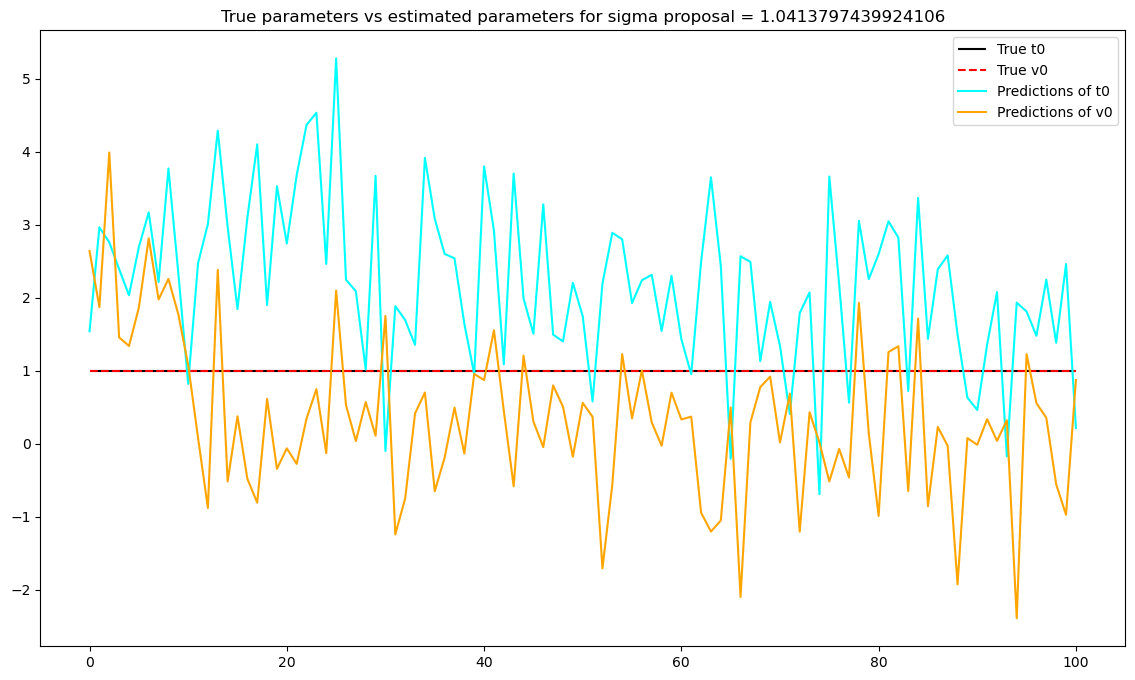

100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Acceptance rate for sigma proposal = 0.1 is :  0.11


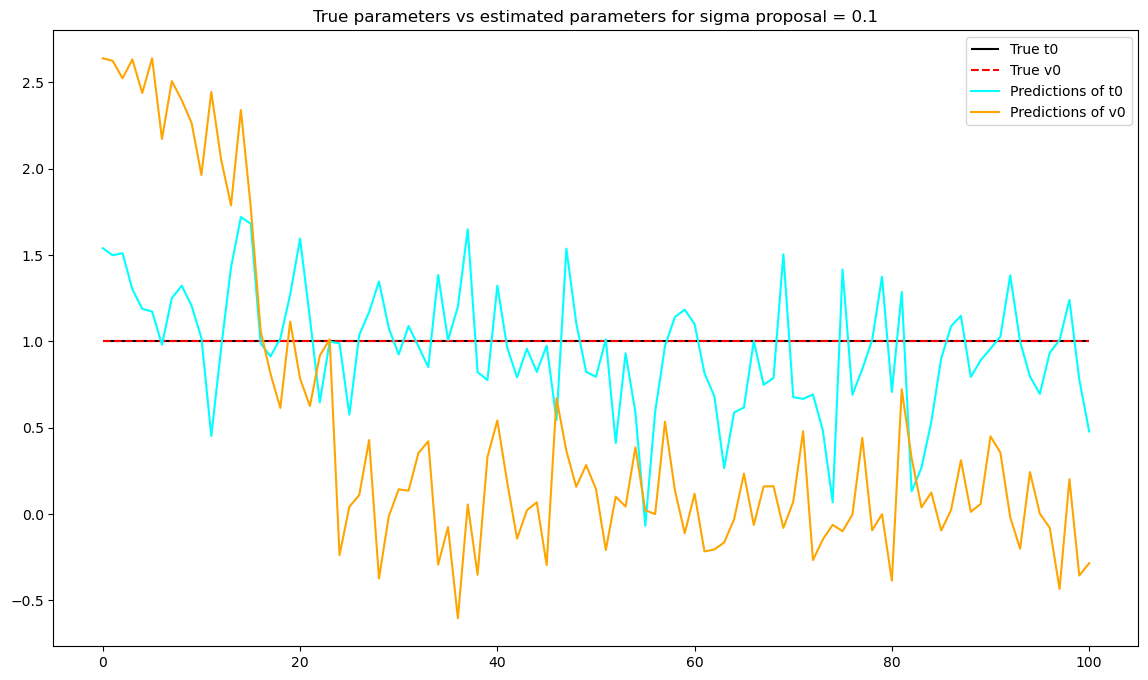

100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Acceptance rate for sigma proposal = 0.5 is :  0.06


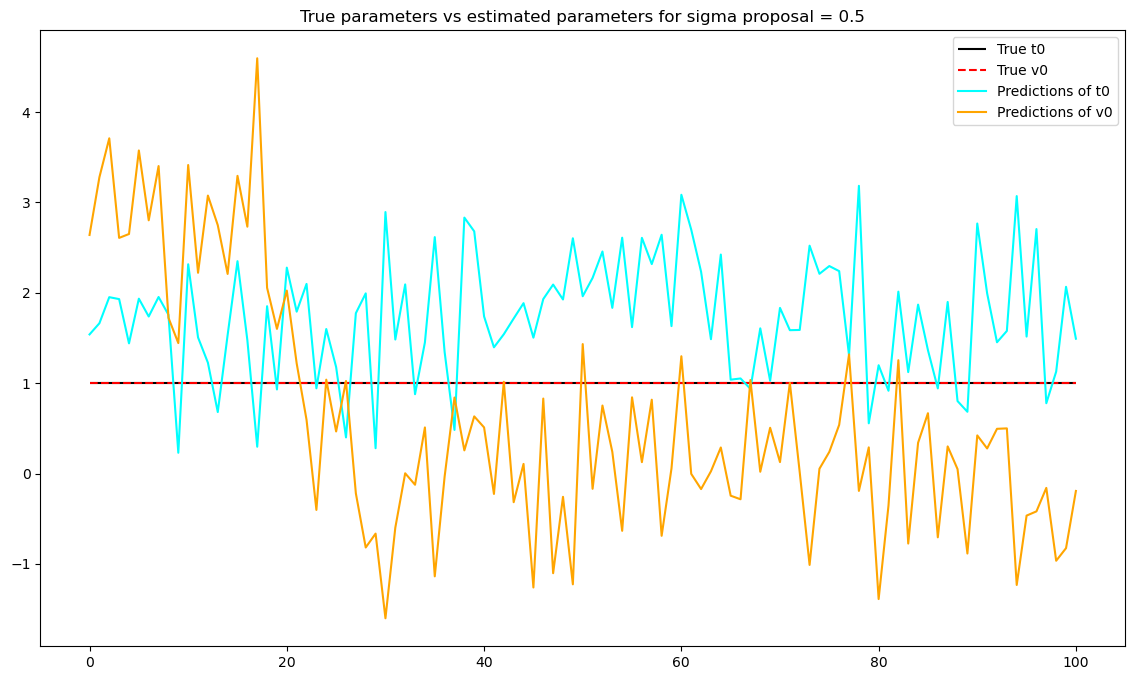

100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


Acceptance rate for sigma proposal = 1 is :  0.06


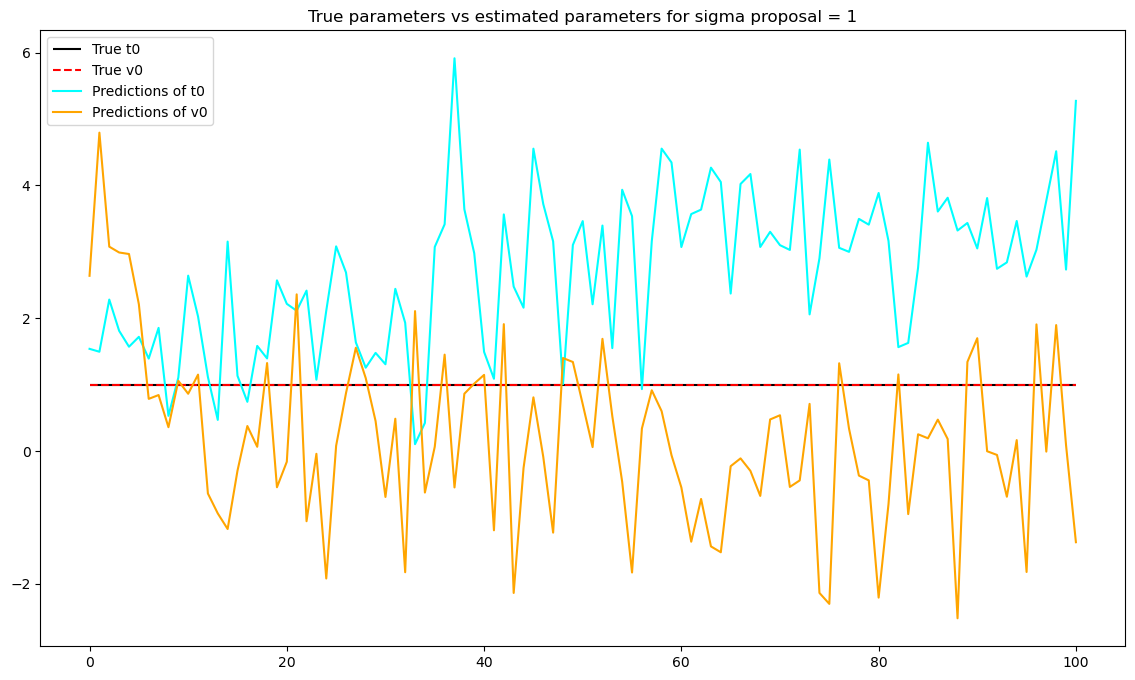

100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


Acceptance rate for sigma proposal = 1.5 is :  0.03


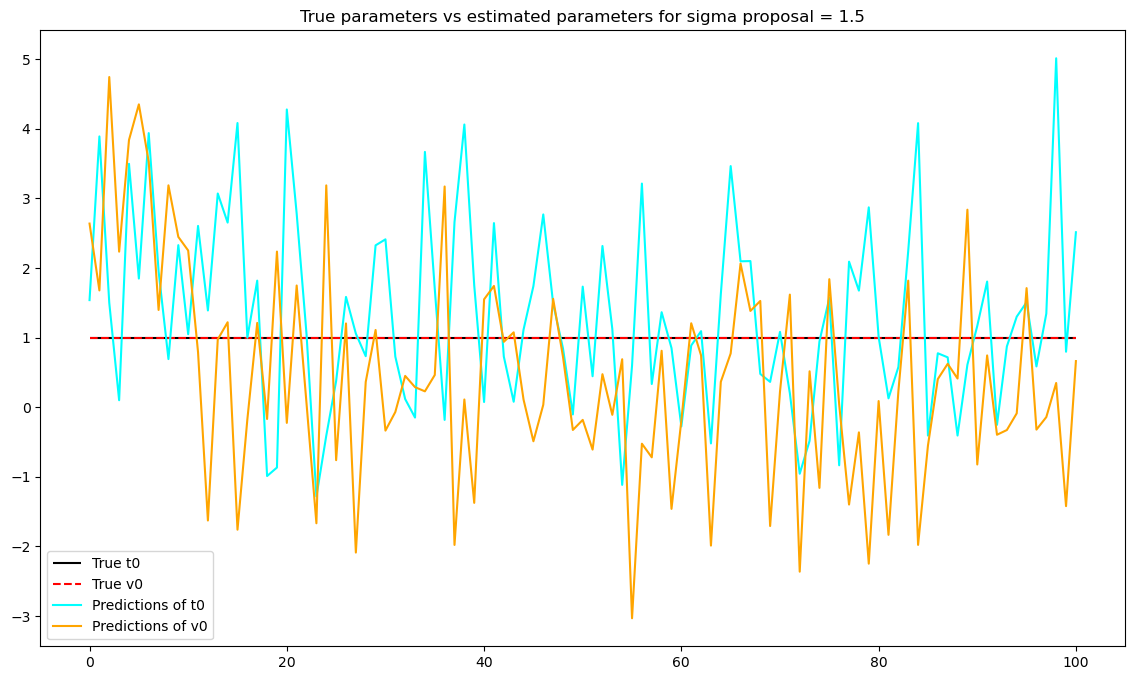

In [50]:
N, ki, p_0, sigma_p0, sigma_v0, sigma_t0, s_t0, s_v0, t0_barbar, v0_barbar = initialize_parameters()

def log_posterior(Y, z, t0_bar, v0_bar, sigma_t0, sigma, sigma_v0, sigma_eps_proposal, sigma_tau_proposal):
    """  Compute the log posterior of the model.
    """
    N = Y.shape[0]
    ki = Y.shape[1]
    t0, v0,  = z[0:2]
    eps, tau = z[2 : N + 1].reshape(-1, 1), z[N + 1:].reshape(-1, 1)
    # Compute the first double sum 
    sum1 = 0 
    for i in np.arange(N-1):
        d_i = individual_trajectory(p_0, v0, t0, np.exp(eps[i]), tau[i])
        sum_i_j = 0
        for j in range(ki):
            sum_i_j += ((Y[i, j] - d_i(j)[0]) ** 2) / 2 * sigma
        sum1 += sum_i_j
    
    # Compute the other sum 
    sum2 = np.sum([tau[i] ** 2 / 2 * sigma_tau_proposal for i in range(N-1)]
                  + [eps[i] ** 2 / 2 * sigma_eps_proposal for i in range(N-1)] 
                  + (t0 - t0_bar) ** 2 / (2 * sigma_t0**2)
                  + (v0 - v0_bar) ** 2 / (2 * sigma_v0 ** 2))
    
    return -(sum1 + sum2)

def Symmetric_Random_Walk_HM(Y, z_init, t0_bar, v0_bar, sigma_eps, sigma_tau, sigma, sigma_prop, maxIter = 10 ** 4):
    z = z_init
    acceptances = 0
    evol_t0 = [z_init[0]]
    evol_v0 = [z_init[1]]
    for _ in tqdm(range(maxIter)):
        z_proposal = np.sqrt(sigma_prop) * np.random.randn(z.shape[0]) + z    # proposal N(z, sigma_prop)
        evol_t0.append(z_proposal[0])
        evol_v0.append(z_proposal[1])
        # Acceptance ratio
        log_posterior_z = log_posterior(Y, z, t0_bar, v0_bar, sigma_t0, sigma, sigma_v0, sigma_eps, sigma_tau)
        log_posterior_prop = log_posterior(Y, z_proposal, t0_bar, v0_bar, sigma_t0, sigma, sigma_v0, sigma_eps, sigma_tau)
        log_alpha = log_posterior_prop - log_posterior_z
        acceptance_ratio = min(1, np.exp(min(0, log_alpha)))

        # Acceptance rejection
        u = np.random.rand()
        if u < acceptance_ratio:
            z = z_proposal
            acceptances += 1
    return z, (acceptances / maxIter), evol_t0, evol_v0

true_z = np.ones(2 * N + 2)
true_t0 = true_z[0] 
true_v0 = true_z[1] 
true_eps_i = true_z[2 : N + 2].reshape((N,)) 
true_tau = true_z[N + 2 : ].reshape((N,))
init = true_z + 1.5 * np.random.randn(2 + 2 * N)

t0_bar, v0_bar = 1, 1 
sigma_tau, sigma = 0.5, 0.5
sigma_eps = 0.5

for sigma_prop in [1.5 * 10 ** (-2), 10 ** (-2), 1.5 ** 10 ** (-1), 0.1, 0.5, 1, 1.5]:
    z_pred, acceptance_rate, t0_pred, v0_pred = Symmetric_Random_Walk_HM(Y, init, t0_bar, v0_bar, sigma_eps, sigma_tau, sigma, sigma_prop = sigma_prop, maxIter = 100)
    print(f"Acceptance rate for sigma proposal = {sigma_prop} is : " ,acceptance_rate)
    plt.figure(figsize = (14, 8))
    plt.title(f"True parameters vs estimated parameters for sigma proposal = {sigma_prop}")
    plt.hlines(true_t0, xmin=0, xmax=len(t0_pred)-1, label = "True t0", color = "black")
    plt.hlines(true_v0, xmin=0, xmax=len(v0_pred)-1,  label = "True v0", color = "red", linestyle = "--")
    plt.plot(t0_pred, label = "Predictions of t0", color = "cyan")
    plt.plot(v0_pred, label = "Predictions of v0", color = "orange")
    plt.legend()
    plt.show()


#### 4- Implement the HM-SAEM in order to find the MAP

In [ ]:
N, ki, p_0, sigma_p0, sigma_v0, sigma_t0, s_t0, s_v0, t0_barbar, v0_barbar = initialize_parameters()

def Maximization_Step(T):
    """ Maximization step for the MCMC algorithm
    """
    T1 = T[0]
    T2 = T[1]
    T3 = T[2]
    T4 = T[3]
    T5 = T[4]
    sigma_star = 
    
    

def MCMC_SAEM(Y, sigma_init, sigma_tau_init, sigma_eps_init, t0_bar_init, v0_bar_init, sigma_prop = 0.01, burn_in = 50, maxIter = 10 ** 4):
    """ For for curved exponential family """
    sigma = sigma_init
    sigma_tau = sigma_tau_init
    sigma_eps = sigma_eps_init
    t0_bar = t0_bar_init
    v0_bar = v0_bar_init

    evol_t0_bar = [t0_bar]
    evol_v0_bar = [v0_bar]
    evol_sigma = [sigma]
    evol_sigma_tau = [sigma_tau]
    evol_sigma_eps = [sigma_eps]
    
    # Initialization of the parameters
    z_init = np.zeros(2 * N + 2)
    T = np.zeros((5,1))

    t0_init = z_init[0]
    v0_init = z_init[1]
    eps_init = z_init[2:N+2]
    tau_init = z_init[N+2:]

    # Compute the double sum
    double_sum = 0 
    for i in np.arange(N):
        d_i = individual_trajectory(p_0, v0_init, t0_init, np.exp(eps_init[i]), tau_init[i])
        sum_i_j = 0
        for j in range(ki):
            sum_i_j += ((Y[i, j] - d_i(j)[0]) ** 2) / 2 * sigma
        double_sum += sum_i_j

    T[0] = (double_sum) / 2     # definition is given page 7 of the pdf file 
    T[1] = np.sum(tau_init ** 2) / 2 
    T[2] = np.sum(eps_init ** 2) / 2
    T[3] = t0_init / sigma_t0 
    T[4] = v0_init / sigma_v0

    for k in range(maxIter):
        z = 

## Exercise 2 - Multiplicative Hasting-Metropolis

### Question 3 - Implement this sampler for two different target distributions : the first one being a distribution from which we can sample using the inverse transform method and the second one is of your choice.

In [28]:
def Multiplicative_HM(x0, target_distribution, n_sample):
    """ Multiplicative Hastings Metropolis algorithm
    """
    eps = np.random.uniform(-1, 1, n_sample)
    B = np.random.binomial(1, 0.5, n_sample)
    X = [x0]
    acceptance = 0 
    for i in range(n_sample):
        x = X[-1]
        if B[i] == 0:
            x_prop = x / eps[i]
        else:
            x_prop = x * eps[i]
        alpha = min (
                     1, 
                     (target_distribution(x_prop) * np.abs(x_prop)) / 
                     (target_distribution(x) * np.abs(x))
                    )
        u = np.random.uniform(0, 1)
        if u < alpha:
            acceptance += 1
            X.append(x_prop)
        else:
            X.append(x)
    return X, acceptance / n_sample

##### Distribution that we can sample with the inverse transform method

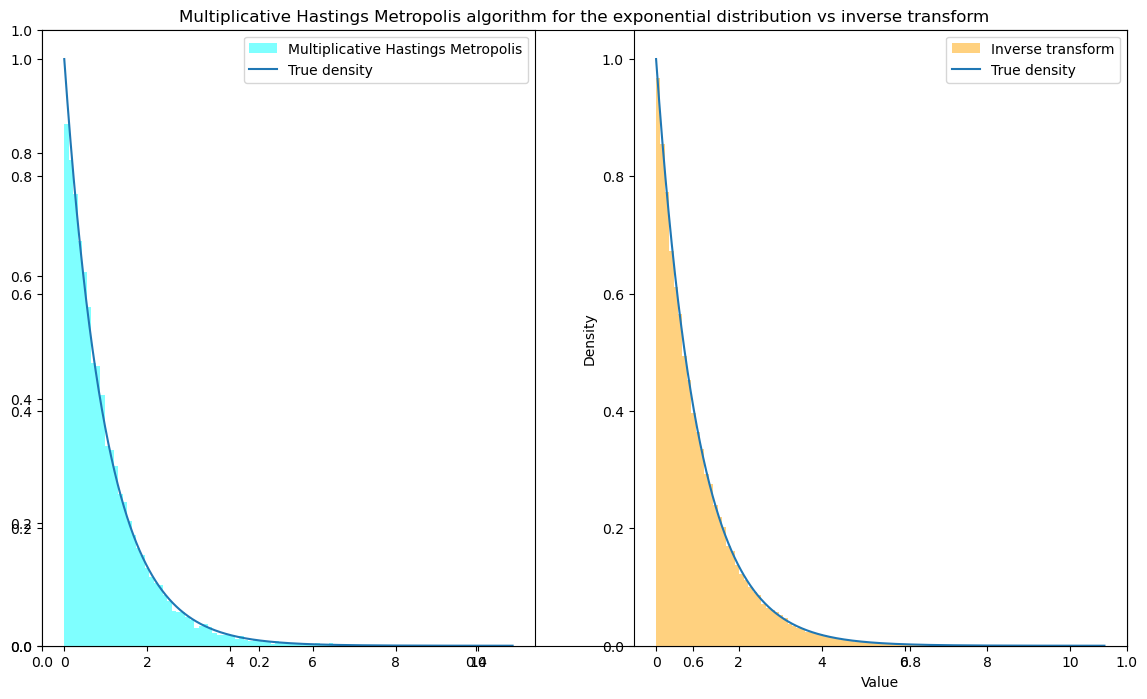

In [30]:
# We've chosen the exponential distribution as the target distribution
n_sample = 10 ** 5
lamb = 1
expon = scipy.stats.expon(scale = lamb)

X_MHM, acceptance_ratio = Multiplicative_HM(x0 = 1, target_distribution = expon.pdf, n_sample = n_sample)
U = np.random.uniform(0, 1, n_sample)
X_inv = - np.log(1 - U) / lamb


x = np.linspace(0, max(X_MHM), 1000)
exp = expon.pdf(x)

plt.figure(figsize = (14, 8))
plt.title("Multiplicative Hastings Metropolis algorithm for the exponential distribution vs inverse transform")
plt.subplot(1, 2, 1)
plt.hist(X_MHM, bins = 100, alpha = 0.5, label = "Multiplicative Hastings Metropolis", color = "cyan", density = True)
plt.plot(x , exp  , label = 'True density')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(X_inv, bins = 100, alpha = 0.5, label = "Inverse transform", color = "orange", density = True)
plt.plot(x , exp  , label = 'True density')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [37]:
# Now, we chose a normal distribution as the target distribution

n_sample = 10 ** 5
lamb = 1
normal = scipy.stats.norm(loc = 0, scale = 1)

X_MHM, acceptance_ratio = Multiplicative_HM(x0 = 1, target_distribution = normal.pdf, n_sample = n_sample)
X_numpy = np.random.normal(0, 1, n_sample)


x = np.linspace(min(X_MHM), max(X_MHM), 1000)
norm = normal.pdf(x)

print(acceptance_ratio)

plt.figure(figsize = (14, 8))
plt.title("Multiplicative Hastings Metropolis algorithm for the normal distribution vs numpy random normal")
plt.subplot(1, 2, 1)
plt.hist(X_MHM, bins = 100, alpha = 0.5, label = "Multiplicative Hastings Metropolis", color = "cyan", density = True)
plt.plot(x , norm  , label = 'True density')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(X_numpy, bins = 100, alpha = 0.5, label = "Numpy", color = "orange", density = True)
plt.plot(x , norm  , label = 'True density')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()